1. <a href="#define functions">define functions</a>
2. <a href="#Define paths and capture data">Define paths and capture data</a>
3. <a href="#evaluate categorical features">evaluate categorical features</a>
4. <a href="#missing data">missing data</a>
5. <a href="#anomaly detection">anomaly detection</a>
6. <a href="#Visualize pairwise relations">Visualize pairwise relations</a>
7. <a href="#Check if data is imbalanced">Check if data is imbalanced</a>

In [901]:
import os
import re
import sys
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle as pkl
import seaborn as sns
from impyute.imputation.cs import fast_knn
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from scipy import stats

# %matplotlib inline
warnings.filterwarnings('ignore')

# set sandbox_mode boolean for image building
* if sandbox_mode = True: faster to run, but images won't be generated

In [902]:
sandbox_mode = False

# <a id="define functions">define functions</a>

In [903]:
def get_numerical_mask(df):
    type_mask = []
    for i in df.dtypes:
        if str(i).startswith('float') or str(i).startswith('int'): # or str(i).startswith('bool')
            type_mask.append(True)
        else: type_mask.append(False)
    num_cols = list(np.array(df.columns)[type_mask])
    other_cols = list(np.array(df.columns)[[not elem for elem in type_mask]])
    
    return num_cols, other_cols

### functions for visualizations

In [904]:
# build boxplots
def build_boxplots(df, x, file):
    
    plt.close()
    
    cols = df.columns
    fig, axes = plt.subplots(1,len(cols),figsize=(15,5))

    for ax,col in zip(axes, cols):
        sns.boxplot(x = x, y = col, data = df, ax = ax, width=.1)
    plt.tight_layout()
    plt.plot()
    
    # save file
    file = '01boxplot_'+file+'.jpg'
    plt.savefig(os.path.join(reports,file), bbox_inches = "tight")
    
# plot distributions
def plot_dist(feature, target, name, xlabel):
    fig, axes = plt.subplots(1,2,figsize=(15,5))
    ax1, ax2 = axes[0], axes[1]

    ax1 = sns.distplot( feature, hist=True, kde=True, bins=int(180/5), ax=ax1 )
    ax1.set_ylabel('frequency and KDE')
    ax1.set_xlabel(xlabel)
    ax1.set_title('{} histogram'.format(xlabel));

    ax2 = sns.kdeplot(feature[(target == 0) ],
                    color="Red", shade = True, ax = ax2)
    ax2 = sns.kdeplot(feature[(target == 1) ],
                    color="Blue", shade= True, ax = ax2)
    ax2.legend(["Not Churn", "Churn"], loc='upper right')
    ax2.set_ylabel('Density')
    ax2.set_xlabel('{}'.format(xlabel))
    ax2.set_title('Density function of {}'.format(xlabel));

    # save file
    file = '03hist_kde_'+name+'.jpg'
    plt.savefig(os.path.join(reports,file), bbox_inches = "tight")

### functions related to missing data

In [905]:
def get_missing(df):
    total = df.isnull().sum()
    percent = (df.isnull().sum()/df.isnull().count())
    missing_data = pd.concat([total, percent], axis=1, keys=['total', 'percent_missing'])
    missing_data['percent_missing'] = missing_data['percent_missing']
    missing_data['percent_missing'] = missing_data['percent_missing'].apply(lambda x: round(x,2))
    
    return missing_data

def drop_missing_from_threshold(df, row_threshold, col_threshold):
    row_count, col_count = df.shape
    # drop columns according to threshold of missing; use mask of columns which have less missing than threshold
    df = df.iloc[:, (df_missing['percent_missing'] < col_threshold).to_list()]
    
    # drop row according to threshold of missing
    n_cols = df.shape[1]
    df['ratio_mis'] = df.apply(lambda x: (n_cols - x.count())/n_cols, axis=1)
    df = df[df['ratio_mis']<row_threshold]
    df.drop(['ratio_mis'], axis=1, inplace=True)
    
    # count number of removals
    row_count_new, col_count_new = df.shape
    row_count_removal = row_count - row_count_new
    col_count_removal = col_count - col_count_new
    print('{} rows and {} columns were removed from database'.format(row_count_removal, col_count_removal))
    
    return df

def apply_imputation(df, method = 'knn', k=30, manual_val=-1):
    try:
        assert method in ['knn', 'mode', 'median', -1, 'manual']
    except AssertionError:
        raise ValueError('error: select a correct method for imputation: [knn, mode, median, -1, manual]')
        
    if method == 'knn':
        sys.setrecursionlimit(100000) #Increase the recursion limit of the OS
        numerical_cols, other_cols = get_numerical_mask(df)
        
#         df =  StandardScaler().fit_transform(df) # scale for knn to work properly (it's distance based)

        # start the KNN training
        imputed_training = fast_knn(df[numerical_cols], k=30)

        # retrieve column names
        imp_cols = imputed_training.columns.to_list()
        imputed_training.rename({imp_cols[i]: numerical_cols[i] for i in range(len(imp_cols))}, axis = 1, inplace=True)
        df.reset_index(inplace=True)
        other_cols.append('id')
        df = df[other_cols].merge(imputed_training, left_index=True, right_index=True)
        df.set_index('id', inplace=True)
        
    elif method == 'mode':
        df.fillna(data.mode().iloc[0], inplace=True)
        
    elif method == 'median':
        df.fillna(df.median(), inplace=True)

    elif method == -1:
        df.fillna(-1, inplace=True)
    
    elif method == 'manual':
        df.fillna(manual_val, inplace=True)
        
    try:
        assert df[df.isna().any(axis=1)].shape[0] == 0
    except AssertionError:
        raise ValueError('there are still missing values')
    
    return df

### functions related to outliers

In [906]:
def apply_standard_deviation_tol(df, tol=3):
    #scale data for operation
    df = pd.DataFrame(StandardScaler().fit_transform(df[numerical_cols]))
    
    z = np.abs(stats.zscore(df))
    z = pd.DataFrame(z, columns = df.columns, index=df.index)
    z.fillna(0, inplace=True)
    for col in z.columns[2:]:
        z = z[z[col]<tol]
    print("{0:.2%} of data was removed after dealing with outliers".format((df.shape[0]-z.shape[0])/df.shape[0]))
    df = df.loc[z.index, :]
    
    return df

def apply_isolation_forest(df, contamination=0.05):
    clf = IsolationForest(max_samples='auto', contamination=contamination, random_state=42) # contamination='auto' or 0.05
    clf.fit(df)

    outlier_pred = clf.predict(df)
    print('number of outliers:', np.count_nonzero(outlier_pred == -1), 'from a total of {}'.format(len(outlier_pred)))
    print('percentage of outliers: {0:.0%}'.format(np.count_nonzero(outlier_pred == -1)/np.count_nonzero(outlier_pred == 1)))
    
    return outlier_pred

def get_outliers(df, label, cols, method = 'isolation_forest', if_contamination = 0.05, z_tol = 3):
    
    # separate numerical data for treatment
    df_filtered = df[cols]
    
    if method == 'isolation_forest':
        outliers = apply_isolation_forest(df_filtered, if_contamination)
    elif method == 'standard_deviation_tol':
        df = apply_standard_deviation_tol(df_filtered, z_tol)
    
    return outliers, label

#### outlier analysis

In [907]:
import operator

def get_outlier_dict(df):
    df = df.copy()
    mult = 1.5
    n_outliers = {}
    for var in df.columns:
        quart1 = data[var].quantile(0.25)
        quart3 = data[var].quantile(0.75)
        iqr = quart3 - quart1
        lower_bound = quart1 - mult*iqr
        upper_bound = quart3 + mult*iqr
        df.loc[(df[var] < lower_bound) | (df[var] > upper_bound), [var]] = True
        df.loc[(df[var] != True), [var]] = False
        out_count = df[df[var]==True].shape[0]
        n_outliers[var] = out_count

    tup_results = sorted(n_outliers.items(), key=operator.itemgetter(1), reverse=True)
    ordered_cols = list(list(zip(*tup_results))[0])

    out_check = []
    n_outliers = {}
    for var in ordered_cols:
        for check in out_check:
            df.loc[(df[check] == True), [var]] = False
        out_check.append(var)
        out_count = df[df[var]==True].shape[0]
        if out_count != 0: n_outliers[var] = out_count
    return n_outliers
            
def plot_outliers(results, strings):
    file = '{}.jpg'.format(strings['filename'])
    tup_results = sorted(results.items(), key=operator.itemgetter(1))

    N = len(results)
    ind = np.arange(N)  # the x locations for the groups
    width = 0.40       # the width of the bars

    fig = plt.figure(figsize=(16,2))
    ax = fig.add_subplot(111)
    rects = ax.bar(ind+0.5, list(zip(*tup_results))[1], width,)
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x()+rect.get_width()/2., 
                1.005*height, 
                height, 
                ha='center', 
                va='bottom',)

    ax.set_xlabel('{}'.format(strings['xlabel']))
    ax.set_ylabel('{}'.format(strings['ylabel']))
    ax.set_title('{}'.format(strings['title']))
    
    # set ylim
    ylim = max(results.values())*1.2
    ax.set_ylim([0, ylim])
        
    ax.set_xticks(ind + width/2.)
    ax.set_xticklabels(list(zip(*tup_results))[0], rotation=22)
#     print("Order of models:", list(zip(*tup_results))[0])
    
    plt.plot()
    plt.savefig(os.path.join(reports,file), bbox_inches = "tight")

# <a id="Define paths and capture data">Define paths and capture data</a>

In [909]:
inputs = os.path.join('..', 'data', '02_intermediate')
outputs = os.path.join('..', 'data', '02_intermediate')
reports = os.path.join('..', 'data', '06_reporting')

In [910]:
data               = pd.read_csv(os.path.join(inputs, 'X_train.csv'), index_col='id')
data_test          = pd.read_csv(os.path.join(inputs, 'X_test.csv'), index_col='id')
y_train            = pd.read_csv(os.path.join(inputs, 'y_train.csv'), index_col='id')
y_test             = pd.read_csv(os.path.join(inputs, 'y_test.csv'), index_col='id')

In [911]:
print('Dataset dimensions:', data.shape)
data.head()

Dataset dimensions: (4930, 19)


,gender_male,seniorcitizen,partner,dependents,tenure,phoneservice,multiplelines,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies,contract,paperlessbilling,paymentmethod,monthlycharges,totalcharges
id,,,,,,,,,,,,,,,,,,,
7590-vhveg,0.0,0,1.0,0.0,1,0.0,no phone service,dsl,0.0,1.0,0.0,0.0,no,0.0,month-to-month,1.0,electronic check,29.85,29.85
5575-gnvde,1.0,0,0.0,0.0,34,1.0,no,dsl,1.0,0.0,1.0,0.0,no,0.0,one year,0.0,mailed check,56.95,1889.50
3668-qpybk,1.0,0,0.0,0.0,2,1.0,no,dsl,1.0,1.0,0.0,0.0,no,0.0,month-to-month,1.0,mailed check,53.85,108.15
7795-cfocw,1.0,0,0.0,0.0,45,0.0,no phone service,dsl,1.0,0.0,1.0,1.0,no,0.0,one year,0.0,bank transfer (automatic),42.30,1840.75
9237-hqitu,0.0,0,0.0,0.0,2,1.0,no,fiber optic,0.0,0.0,0.0,0.0,no,0.0,month-to-month,1.0,electronic check,70.70,151.65


# Checking  for possible anomalies in the database

In [912]:
data.describe()

,gender_male,seniorcitizen,partner,dependents,tenure,phoneservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingmovies,paperlessbilling,monthlycharges,totalcharges
count,4930.000000,4930.000000,4930.000000,4930.000000,4930.000000,4930.000000,3850.000000,3850.000000,3850.000000,3850.000000,3850.000000,4930.000000,4930.000000,4922.000000
mean,0.506897,0.159229,0.480933,0.296146,32.337120,0.908722,0.367792,0.441818,0.444416,0.367532,0.499481,0.588641,64.853824,2282.250772
std,0.500003,0.365927,0.499687,0.456603,24.633947,0.288033,0.482267,0.496668,0.496965,0.482196,0.500065,0.492130,30.140715,2270.485234
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,18.250000,18.800000
25%,0.000000,0.000000,0.000000,0.000000,9.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,35.512500,392.537500
50%,1.000000,0.000000,0.000000,0.000000,29.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,70.450000,1401.700000
75%,1.000000,0.000000,1.000000,1.000000,56.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,89.950000,3775.050000
max,1.000000,1.000000,1.000000,1.000000,72.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,118.750000,8684.800000


# get types of columns

In [913]:
numerical_cols, other_cols = get_numerical_mask(data)
boolean_vars = ['partner', 'dependents', 'phoneservice', 'onlinesecurity', 'onlinebackup', 'deviceprotection', 
            'techsupport', 'streamingmovies', 'paperlessbilling']
boolean_vars.extend(['seniorcitizen', 'gender_male'])
for col in boolean_vars:
    numerical_cols.remove(col)

# boxplots
This is useful to check for outliers, which will be handled later.

In [914]:
partition = int(len(numerical_cols)/1)

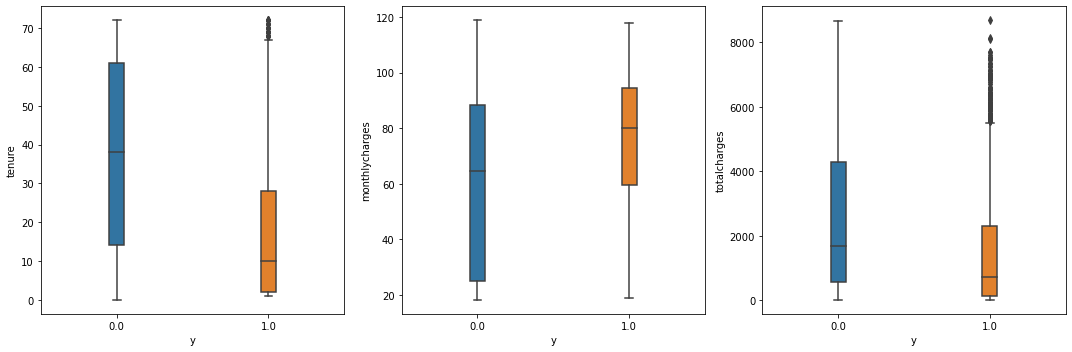

In [915]:
if not sandbox_mode:
    build_boxplots(data[numerical_cols[:partition*1]], y_train['y'], '01')

# <a id="evaluate categorical features">evaluate categorical features</a>

In [916]:
categories_dict = {}
for cat in data.columns:
    if data[cat].dtypes == 'object':
        categories_dict[cat] = list(data[cat].unique())
        n_categories = data[cat].unique().size
        print("number of categories for variable '{}': {} ".format(cat, n_categories))

number of categories for variable 'multiplelines': 3 
number of categories for variable 'internetservice': 3 
number of categories for variable 'streamingtv': 3 
number of categories for variable 'contract': 3 
number of categories for variable 'paymentmethod': 4 


# distribution of categorical vars
By assessing the proportion of positive cases over the categorical variables, we can observe some interesting factors:
* Except for the variable "multiplelines", the proportion might vary a lot according to the specific category.
* For internet service, the fiber optic users have a higher proclivity to churn.
* month-to-month users have a high chance to churn (40%). 2 years contracts have extremely low churn (just 7%).
* for payment method, payment checks users also might churn more frequently.

In [917]:
def get_cat_vis(df, cat, y):
    df = df.copy()
    df['y'] = y
    print('selected feature:', feature)
    print('proportion of positive cases')
    multiplers = (df[df['y']==1][cat].value_counts() / df[cat].value_counts()).sort_values(ascending=False).head()
    print(multiplers)
    sns.catplot(x=cat, kind="count", hue="y", data=df, height=4);

In [918]:
print('there are {} categorical variables'.format(len(categories_dict.keys())))
print('from a total of {}'.format(data.shape[1]))

there are 5 categorical variables
from a total of 19


In [919]:
# cat = cat_list[0]
# plt.xticks(rotation=45)
# data[cat].hist(bins=16, alpha = .5, figsize=(10,3));

In [920]:
cat_list = list(categories_dict.keys())

selected feature: multiplelines
proportion of positive cases
yes                 0.282732
no                  0.245784
no phone service    0.244444
Name: multiplelines, dtype: float64


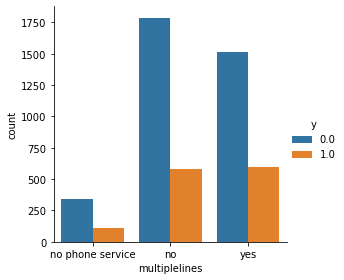

In [921]:
feature = cat_list[0]
get_cat_vis(data, feature, y_train['y'])

selected feature: internetservice
proportion of positive cases
fiber optic    0.416898
dsl            0.185273
no             0.068519
Name: internetservice, dtype: float64


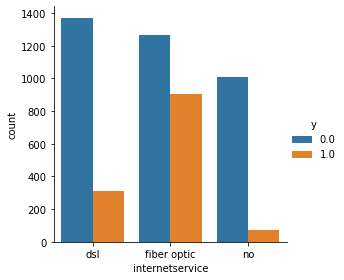

In [922]:
feature = cat_list[1]
get_cat_vis(data, feature, y_train['y'])

selected feature: streamingtv
proportion of positive cases
no                     0.334523
yes                    0.295924
no internet service    0.068519
Name: streamingtv, dtype: float64


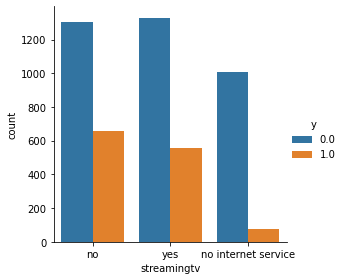

In [923]:
feature = cat_list[2]
get_cat_vis(data, feature, y_train['y'])

selected feature: contract
proportion of positive cases
month-to-month    0.421709
one year          0.108717
two year          0.023689
Name: contract, dtype: float64


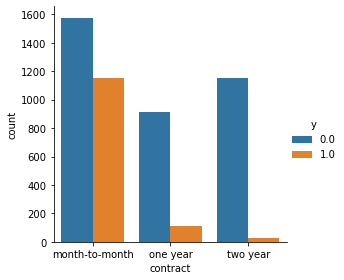

In [924]:
feature = cat_list[3]
get_cat_vis(data, feature, y_train['y'])

selected feature: paymentmethod
proportion of positive cases
electronic check             0.454711
mailed check                 0.186941
bank transfer (automatic)    0.164534
credit card (automatic)      0.141659
Name: paymentmethod, dtype: float64


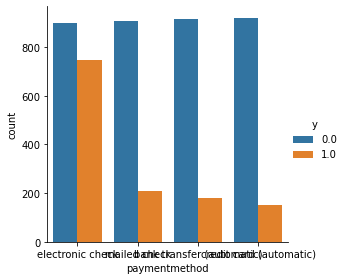

In [925]:
feature = cat_list[4]
get_cat_vis(data, feature, y_train['y'])

# distribution of boolean vars


selected feature: partner
proportion of positive cases
0.0    0.325909
1.0    0.191902
Name: partner, dtype: float64


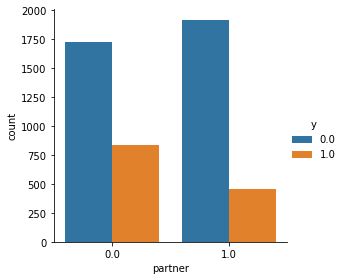

In [926]:
feature = boolean_vars[0]
get_cat_vis(data, feature, y_train['y'])

selected feature: dependents
proportion of positive cases
0.0    0.307493
1.0    0.152055
Name: dependents, dtype: float64


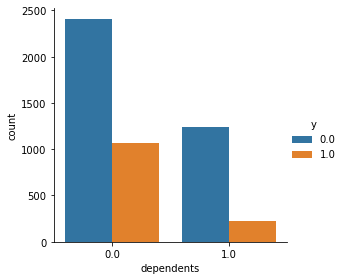

In [927]:
feature = boolean_vars[1]
get_cat_vis(data, feature, y_train['y'])

selected feature: phoneservice
proportion of positive cases
1.0    0.263170
0.0    0.244444
Name: phoneservice, dtype: float64


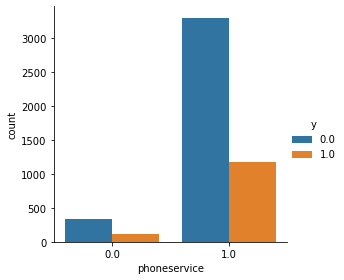

In [928]:
feature = boolean_vars[2]
get_cat_vis(data, feature, y_train['y'])

selected feature: onlinesecurity
proportion of positive cases
0.0    0.416187
1.0    0.142655
Name: onlinesecurity, dtype: float64


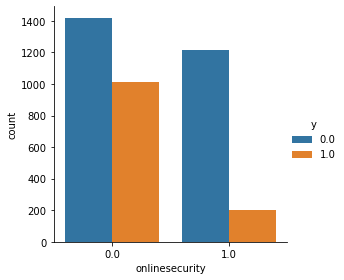

In [929]:
feature = boolean_vars[3]
get_cat_vis(data, feature, y_train['y'])

selected feature: onlinebackup
proportion of positive cases
0.0    0.396463
1.0    0.213404
Name: onlinebackup, dtype: float64


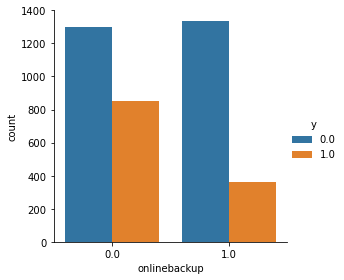

In [930]:
feature = boolean_vars[4]
get_cat_vis(data, feature, y_train['y'])

selected feature: deviceprotection
proportion of positive cases
0.0    0.392707
1.0    0.219170
Name: deviceprotection, dtype: float64


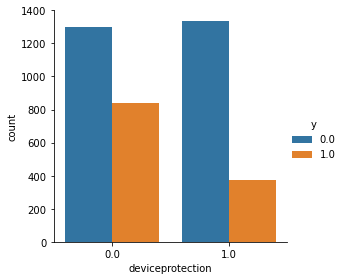

In [931]:
feature = boolean_vars[5]
get_cat_vis(data, feature, y_train['y'])

selected feature: techsupport
proportion of positive cases
0.0    0.417659
1.0    0.139929
Name: techsupport, dtype: float64


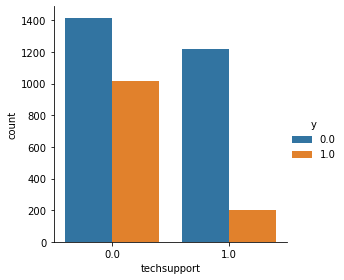

In [932]:
feature = boolean_vars[6]
get_cat_vis(data, feature, y_train['y'])

selected feature: streamingmovies
proportion of positive cases
0.0    0.334717
1.0    0.296412
Name: streamingmovies, dtype: float64


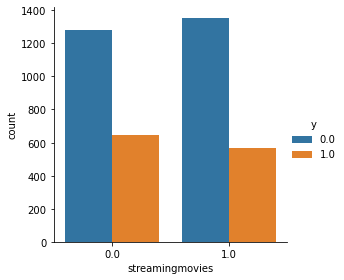

In [933]:
feature = boolean_vars[7]
get_cat_vis(data, feature, y_train['y'])

selected feature: paperlessbilling
proportion of positive cases
1.0    0.330462
0.0    0.162722
Name: paperlessbilling, dtype: float64


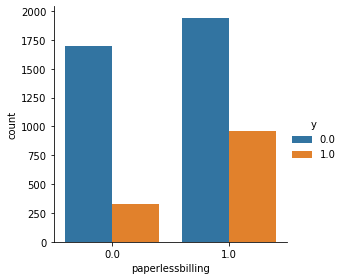

In [934]:
feature = boolean_vars[8]
get_cat_vis(data, feature, y_train['y'])

# <a id="missing data">missing data</a>

usually, missing data is solved by filling it with some metric such as median. If the number of missing data in some entry is too high, we must evaluate for the removal of those entries.
For categorical with missing data, if you want to encode missing values, first change its type to a string:
```python
a[pd.isnull(a)]  = 'NaN'
```
Some refs:
* https://stackoverflow.com/questions/36808434/label-encoder-encoding-missing-values

About the missing values, we can't assume beforehand if those are Missing at Random (MAR) or Missing not at Random (MNAR). Further investigation would be necessary to properly decide over how to handle it.

For now, I am assuming they are Missing at Random. So I will remove some of them through a threshold, and apply imputation for the rest. By applying a proper imputation I observed a slight improvement over the score.

The catch is that applying imputation over euclidean distances can be extremely imprecise.

### drop columns and rows for threshold of missing

In [935]:
print('SORTED LIST OF MISSING VALUES')
df_missing = get_missing(data)
df_missing_vis = df_missing[df_missing['total'] > 0]
df_missing_vis['percent_missing'] = df_missing_vis['percent_missing'].apply(lambda x: round(x, 2))
# df_missing_vis.sort_values(by='percent_missing', ascending=False).head(20)
df_missing_vis.sort_values(by='percent_missing', ascending=False)

SORTED LIST OF MISSING VALUES


,total,percent_missing
onlinesecurity,1080,0.22
onlinebackup,1080,0.22
deviceprotection,1080,0.22
techsupport,1080,0.22
streamingmovies,1080,0.22
totalcharges,8,0.00


In [936]:
col_mis_threshold = 0.8
row_mis_threshold = 0.5

In [937]:
data = drop_missing_from_threshold(data, row_mis_threshold, col_mis_threshold)

0 rows and 0 columns were removed from database


### visualize rows with missing
we already know that the critical columns are related to geo_location

In [938]:
# sandbox_mode = True
if sandbox_mode:
    print('number of missing:', data[data.isna().any(axis=1)].shape[0])
    data[data.isna().any(axis=1)].tail()

### imputation of missing values
For continuous values, I would prefer knn over median, but it depends on normalized dataset. Nevertheless, we don't have missing on continuous datasets, even though we could encode categorical data. But the encoding step wasn't organized to precede this notebook, so I will stick to 'mode', which imputes the most frequent value.

Some refs:
* https://jamesrledoux.com/code/imputation#:~:text=One%20approach%20to%20imputing%20categorical,given%20in%20Pandas'%20value_counts%20function.

the apply_imputation function accepts the following methods: knn, median, mode, or -1 (impute as category -1 [for categorical vars])

In [939]:
# imputation over numerical variables
data[numerical_cols] = data[numerical_cols].astype(float)
if data[numerical_cols].isnull().values.any():
    data[numerical_cols] = apply_imputation(data[numerical_cols], method = 'knn', k = 30)

# imputation over categorical variables
# if data[other_cols].isnull().values.any():
data[other_cols] = apply_imputation(data[other_cols], method = 'mode', k = 30)

# manual imputation on lag and forecast variables
# manual_cols = ['lag_1', 'lag_2', 'lag_3']
# if data[manual_cols].isnull().values.any():
#     data[manual_cols] = apply_imputation(data[manual_cols], method = 'manual', manual_val = False)
# data_test['y'].fillna(value=data_test['y'], inplace=True)

In [940]:
# imputation over numerical variables
data_test[numerical_cols] = data_test[numerical_cols].astype(float)
if data_test[numerical_cols].isnull().values.any():
    data_test[numerical_cols] = apply_imputation(data_test[numerical_cols], method = 'knn', k = 30)

# imputation over categorical variables
if data_test[other_cols].isnull().values.any():
    data_test[other_cols] = apply_imputation(data_test[other_cols], method = 'mode', k = 30)

# <a id="anomaly detection">anomaly detection</a>

remove outliers from choosing one of the following methods: isolation_forest, standard_deviation_tol (using z_score on standardized version)

other parameters are:
* if_contamination: isolation forest level of contamination
* z_tol: tolerance for standard deviation (if using zscore)

It is not advisable to remove outliers without proper consideration.

Some interesting refs:
* https://towardsdatascience.com/ways-to-detect-and-remove-the-outliers-404d16608dba
* https://towardsdatascience.com/anomaly-detection-with-isolation-forest-visualization-23cd75c281e2
* https://towardsdatascience.com/outlier-detection-with-isolation-forest-3d190448d45e

In [941]:
# temporarily add train to test data (no leakage here)
test_start = data_test.index[0]
data_test = data.append(data_test)

# get outliers on train data
data['if_anomaly'], _ = get_outliers(data[numerical_cols], y_train, numerical_cols, 
                                                  method = 'isolation_forest', if_contamination = 0.05)

# get outliers on test data (needs trainset)

data_test['if_anomaly'], _ = get_outliers(data_test[numerical_cols], y_train, numerical_cols, 
                                                  method = 'isolation_forest', if_contamination = 0.05)

# removes trainset again
data_test = data_test.iloc[len(data):,:]

number of outliers: 247 from a total of 4930
percentage of outliers: 5%
number of outliers: 353 from a total of 7043
percentage of outliers: 5%


outlier removal isn't justified for now

In [942]:
remove_outliers = False

In [943]:
if remove_outliers:
    data = data[data['if_anomaly'] == 1]
    y_train = y_train[y_train.index.isin(data.index.to_list())]

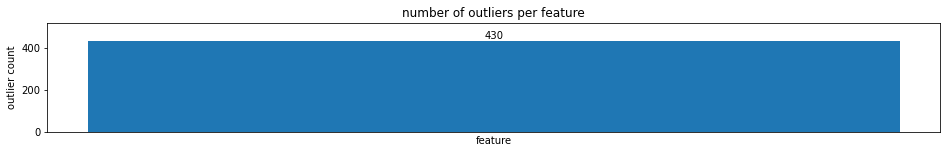

In [944]:
ploting_dict = {'filename': 'outlier_analysis', 'xlabel': 'feature', 'ylabel': 'outlier count', 
                'title': 'number of outliers per feature'}

plot_outliers(get_outlier_dict(data[numerical_cols]), ploting_dict)

# build new variables

# <a id="Visualize pairwise relations">Visualize pairwise relations</a>
When datasets have just a few variables (10–15), pairplots allow for a quick visual inspection of those relations, as well as bariable distributions.

In [945]:
numerical_cols, other_cols = get_numerical_mask(data)
boolean_vars = ['partner', 'dependents', 'phoneservice', 'onlinesecurity', 'onlinebackup', 'deviceprotection', 
            'techsupport', 'streamingmovies', 'paperlessbilling']
boolean_vars.extend(['seniorcitizen', 'gender_male'])
boolean_vars.append('if_anomaly')
for col in boolean_vars:
    numerical_cols.remove(col)

In [946]:
separator = int(len(numerical_cols)/1)

#### group 1

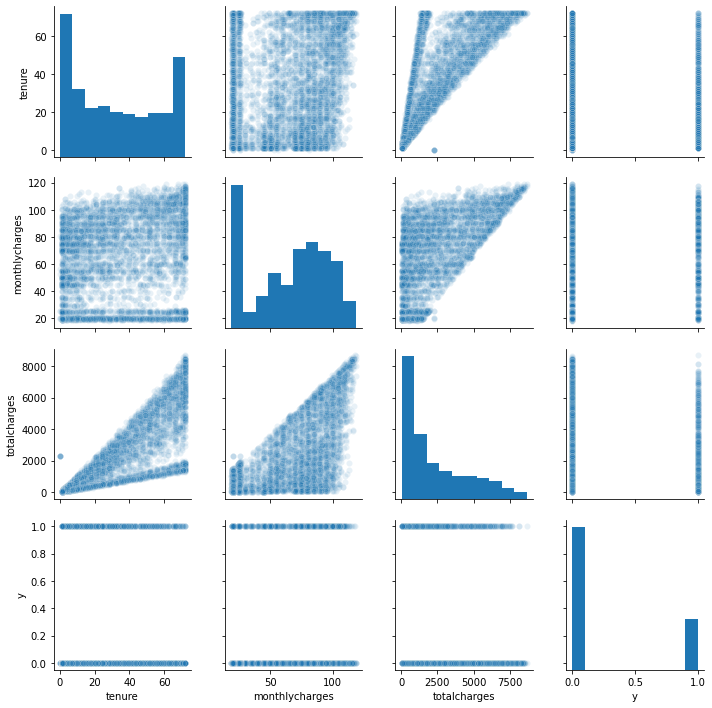

In [947]:
if not sandbox_mode:
    data_vis = data[numerical_cols[:separator]]
    data_vis['y'] = y_train['y']
    sns.pairplot(data_vis, plot_kws={'alpha': 0.1});
    plt.savefig(os.path.join(reports,'01_pairplots_1.jpg'), bbox_inches = "tight")

# check selected distributions

In [948]:
y = y_train['y']

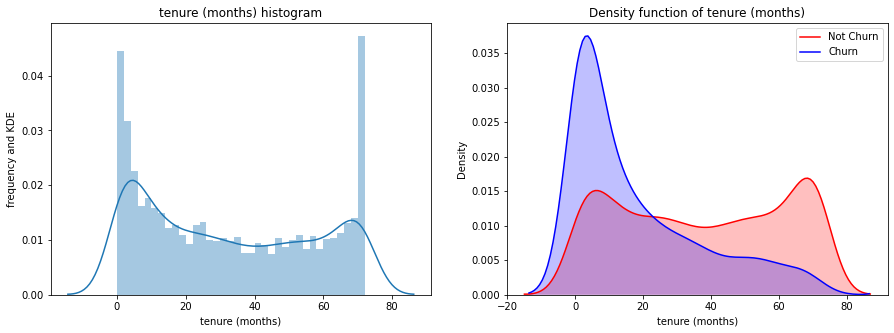

In [971]:
var_name = 'tenure'
plot_dist(data[var_name], y, var_name, xlabel = 'tenure (months)')

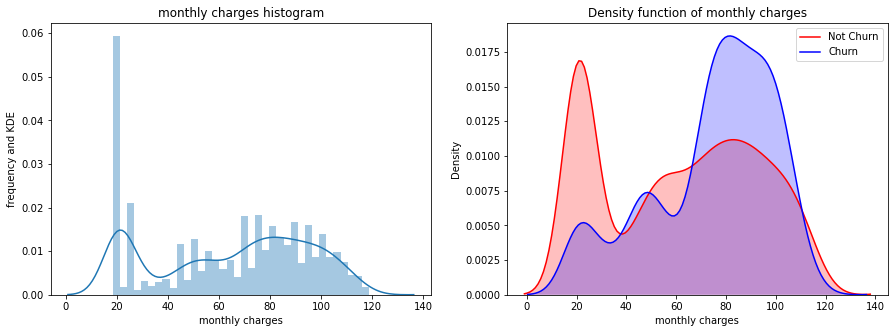

In [892]:
var_name = 'monthlycharges'
plot_dist(data[var_name], y, var_name, xlabel = 'monthly charges')

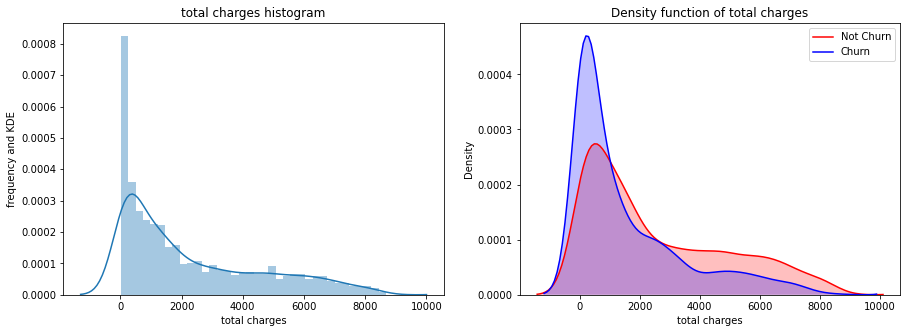

In [893]:
var_name = 'totalcharges'
plot_dist(data[var_name], y, var_name, xlabel = 'total charges')

# <a id="Check if data is imbalanced">Check if data is imbalanced</a>
When data is imbalanced, we must evaluate for solutions such as oversampling or undersamplig, which might be done with techniques such as SMOTE (Synthetic Minority Oversampling Technique).

In [894]:
y = y_train.append(y_test)

In [ ]:
color = sns.color_palette()
classif = y_train['y'].value_counts()
plt.figure(figsize=(8,4))
sns.barplot(classif.index, classif.values, alpha=0.8, color=color[0])
plt.ylabel('Number of occurrences', fontsize=12)
plt.xlabel('Failed', fontsize=12)
plt.plot()
plt.savefig(os.path.join(reports,'imbalance.jpg'), bbox_inches = "tight")

In [ ]:
counts = y['y'].value_counts()
counts

In [ ]:
print('ratio between classes:',round(counts[0]/counts[1],2))
print('\r\nCheck proportions below:')
y['y'].value_counts(normalize=True)

# Description (2nd round)

In [ ]:
if sandbox_mode:
    print(data.shape[0])
    print(y_train.shape[0])
    print(data_test.shape[0])
    print(y_test.shape[0])
    data.describe()

# save intermediate data

In [ ]:
data.to_csv(os.path.join(outputs, 'X_train.csv'))
data_test.to_csv(os.path.join(outputs, 'X_test.csv'))

y_train.to_csv(os.path.join(outputs, 'y_train.csv'))
y_test.to_csv(os.path.join(outputs, 'y_test.csv'))